In [ ]:
#! pip install "snowflake-connector-python[pandas]"
# ! pip install scikit-learn

In [3]:
from snowflake.snowpark import Session
import configparser
def get_session():
    parser = configparser.ConfigParser()
    # Add the credential file name here
    parser.read('config.ini')

    connection_params = dict(user=parser['Credentials']['user'], 
                         password=parser['Credentials']['password'], 
                         account=parser['Credentials']['account'], 
                         warehouse=parser['Credentials']['warehouse'], 
                         database=parser['Credentials']['database'],
                         schema=parser['Credentials']['schema'], 
                         role=parser['Credentials']['role'])

    session = Session.builder.configs(connection_params).create()
    return session

In [4]:
session = get_session()

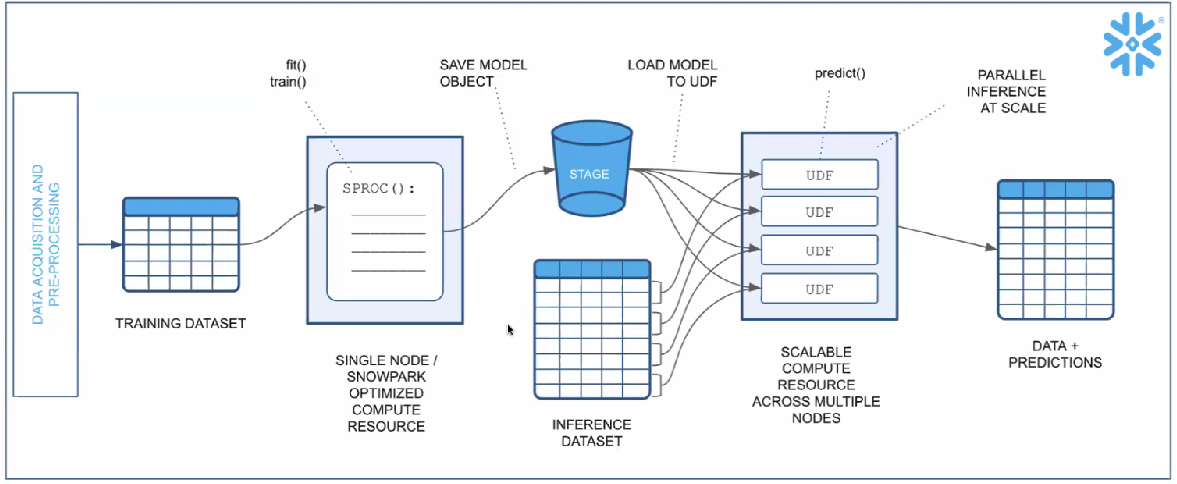

#### Load the prepared data from snowflake

In [3]:
df = session.sql("SELECT * from {table}".format(table="predictive_maintenance_final"))

In [4]:
df.columns

['FAILURE',
 'METRIC5',
 'METRIC6',
 'DAY',
 'DAY_WEEK',
 'SECTOR',
 'OP_PERIOD',
 'DEV_RECONNECTED',
 'MNW1',
 'DIF_M6',
 'DIF_M5',
 'LOG_M2',
 'LOG_M3',
 'LOG_M4',
 'LOG_M7',
 'LOG_M9']

Prepare dataset for training

In [5]:
df_final = df.to_pandas()

In [20]:
def trainer():
    #add all imports
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.metrics import recall_score, f1_score, roc_auc_score, confusion_matrix,classification_report
    from sklearn.linear_model import SGDClassifier
    from sklearn.pipeline import Pipeline
    
    df_final = session.sql("SELECT * from {table}".format(table="predictive_maintenance_final"))
    
    # prepare data for training
    X = df_final.drop(['FAILURE'], axis = 1)
    y = df_final['FAILURE']
    X_train, X_test, Y_train, Y_test = train_test_split(X,y,random_state = 0, test_size=0.25, shuffle = True)
    X_train.reset_index(inplace = True, drop = True)
    Y_train.reset_index(inplace = True, drop = True)

    X_test.reset_index(inplace = True, drop = True)
    Y_test.reset_index(inplace = True, drop = True)
    
    x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, random_state = 0, test_size=0.25)
    
    pipeline = Pipeline([
        ('OHE', OneHotEncoder(handle_unknown = 'ignore',sparse=False)),
#         ('SCALER', StandardScaler()),
        ('SGD', SGDClassifier(random_state=0))
     ])
    
    pipeline.fit(x_train,y_train)
    y_pred = pipeline.predict(x_val) 
    cf_matrix = confusion_matrix(y_val, y_pred)
    cls_report = classification_report(y_val, y_pred, output_dict=True)
    print(cls_report)
    return pipeline, y_pred, cls_report

In [7]:
cls_report = trainer()

/tmp/pip_packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23323
           1       0.00      0.00      0.00        20

    accuracy                           1.00     23343
   macro avg       0.50      0.50      0.50     23343
weighted avg       1.00      1.00      1.00     23343



/tmp/pip_packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/pip_packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/pip_packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
type(cls_report)

str

In [31]:
from snowflake.snowpark import Session
from snowflake.snowpark.functions import sproc

@sproc(name="predictive_maintenance", is_permanent=True, stage_location="@TRAINERS", replace=True, packages=["snowflake-snowpark-python","scikit-learn"])
def train_model(session: Session, features_table: str) -> dict:
    import os
    import time
    from joblib import dump
    start_time = time.time()
    df_final = session.sql("SELECT * from {table}".format(table="predictive_maintenance_final")).to_pandas()
    
    # training code goes here
    
    def trainer():
        #add all imports
        from sklearn.model_selection import train_test_split
        from sklearn.preprocessing import OneHotEncoder
        from sklearn.metrics import recall_score, f1_score, roc_auc_score, confusion_matrix,classification_report
        from sklearn.linear_model import SGDClassifier
        from sklearn.pipeline import Pipeline
    
    # prepare data for training
        X = df_final.drop(['FAILURE'], axis = 1)
        y = df_final['FAILURE']
        X_train, X_test, Y_train, Y_test = train_test_split(X,y,random_state = 0, test_size=0.25, shuffle = True)
        X_train.reset_index(inplace = True, drop = True)
        Y_train.reset_index(inplace = True, drop = True)

        X_test.reset_index(inplace = True, drop = True)
        Y_test.reset_index(inplace = True, drop = True)
    
        x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, random_state = 0, test_size=0.25)
    
        pipeline = Pipeline([
            ('OHE', OneHotEncoder(handle_unknown = 'ignore',sparse=False)),
#         ('SCALER', StandardScaler()),
            ('SGD', SGDClassifier(random_state=0))
         ])
    
        pipeline.fit(x_train,y_train)
        y_pred = pipeline.predict(x_val) 
        cf_matrix = confusion_matrix(y_val, y_pred)
        cls_report = classification_report(y_val, y_pred, output_dict=True)
        print(cls_report)
        return pipeline, cls_report
    pipeline, cls_report = trainer()
    seconds = time.time() - start_time
    time_taken = str(time.strftime("%H:%M:%S",time.gmtime(seconds)))
    from datetime import datetime
    currentDateAndTime = datetime.now()
    model_filename = "Predictive_Maintenance_model_"+currentDateAndTime.strftime('%Y%m%d_%H%M%S') + '.joblib'
    
    model_file_path = os.path.join('/tmp',model_filename)
    dump(pipeline, model_file_path)
    
    session.file.put(model_file_path, "@MODELS" ,overwrite=True)
    
    return {"model_name":model_filename, "classification_report":cls_report}

In [32]:
# test = train_model(session,"predictive_maintenance_final")

In [33]:
session.call("predictive_maintenance",'predictive_maintenance_final')

'{\n  "classification_report": {\n    "0": {\n      "f1-score": 1,\n      "precision": 1,\n      "recall": 1,\n      "support": 3750\n    },\n    "accuracy": 1,\n    "macro avg": {\n      "f1-score": 1,\n      "precision": 1,\n      "recall": 1,\n      "support": 3750\n    },\n    "weighted avg": {\n      "f1-score": 1,\n      "precision": 1,\n      "recall": 1,\n      "support": 3750\n    }\n  },\n  "model_name": "Predictive_Maintenance_model_20230919_194031.joblib"\n}'

### Deploy the model from stage location as a UDF
Once training is completed it will save the model/pipeline to the stage location and return the model name. Using these details we can create a UDF which will help in infering the model stored on stage.

In [5]:
session.clear_imports()
session.clear_packages()
from snowflake.snowpark.functions import udf,call_udf

# Add trained model as dependency
session.add_import("@models/Predictive_Maintenance_model_20230919_194031.joblib.gz")
import pandas
@udf(name='predict', session=session,is_permanent=True,replace=True,stage_location="@SCORE",packages=["snowflake-snowpark-python","pandas", "joblib","scikit-learn"])
def score(payload: list) -> s"tr:
    import sys
    import pandas as pd
    from joblib import load

    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]

    pipeline_file = import_dir + 'Predictive_Maintenance_model_20230919_194031.joblib.gz'
    pipeline = load(pipeline_file)

    prediction = pipeline.predict(df)[0]
    
    return prediction

SyntaxError: EOL while scanning string literal (<ipython-input-5-85cac6f9bda4>, line 9)